## Глабальные настройки

In [ ]:
# Использовать аугментацию для разнообразия данных
USE_AUGMENTATION = False
USE_PRE_TRAINED_CNN = False

## Импорт данных модели (CIFAR10)

In [ ]:
from tensorflow.keras import datasets
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Не нашел иного спосба получить намиенования классов (для читабельности)
# https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ["Самолет", "Авто", "Птица", "Кот", "Олень", "Собака", "Лягушка", "Лошадь", "Корабль", "Грузовик"]


## Библиотеки

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras as keras

from random import randint
from math import floor

from keras import Model, Sequential
from keras.layers import Dense       # полносвязный слой (персептроны)
from keras.layers import Flatten     # для преобразования матр. в массив
from keras.layers import Dropout     # для отключения входов нейронов (для борьбы с переобучением)
from keras.layers import Input       # входной слой (для изменения размерность данных без преобразования)
from keras.layers import Concatenate # для конкатенации массивов

# Для свёртточной нейросети
from keras.layers import Conv2D             # слой свёртки; https://keras.io/api/layers/convolution_layers/convolution2d/
from keras.layers import MaxPool2D          # слой пулинга
from keras.layers import BatchNormalization # слой нормализации (помогает иметь хороший масштаб значений)

# Для аугментации
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras import losses, optimizers
from keras import utils

# для прогресбаров для обучения в keras
from tqdm.keras import TqdmCallback

# для обучения используя Keras
from sklearn.preprocessing import OneHotEncoder

In [ ]:
devices = tf.config.experimental.list_physical_devices("GPU")

if len(devices) > 0:
  #tf.config.experimental.set_memory_growth(devices[0], True)
  pass
else:
  devices = tf.config.experimental.list_physical_devices("CPU")
assert len(devices) > 0, "Something went wrong..."

device_name = devices[0].name
print(f"Running at: {device_name}")

Running at: /physical_device:GPU:0


## Получение информации о датасете

In [ ]:
print(f"Количество картинок для обучения: {len(train_images)}")
print(f"Количество картинок для проверки: {len(test_images)}")

Количество картинок для обучения: 50000
Количество картинок для проверки: 10000


### Функции для отображения картинок

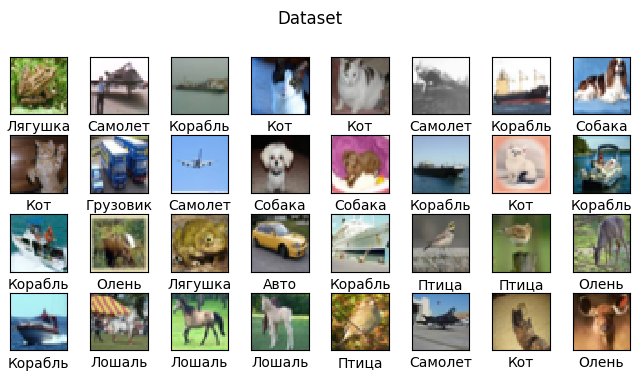

In [ ]:
# Визуализация картинок сеткой
def plot_images(title, w, h, images, names, interpolation = "nearest"):
  assert w * h == len(images), "Incorrect amount of images (must be: %d, but was: %d)" % (w * h, len(images))

  fig, axes = plt.subplots(h, w, figsize = (w, h))
  fig.subplots_adjust(hspace = 0.1, wspace = 0.4)
  fig.suptitle(title)

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], interpolation = interpolation)
    arr_size = len(names[i])

    if arr_size == 2:
      perc = floor(names[i][1] * 10000)
      ax.set_ylabel(str(perc / 100) + "%")

    if arr_size <= 2:
      ax.set_xlabel(class_names[names[i][0]])
    elif arr_size > 2:
      idx = names[i].argmax()
      ax.set_xlabel(class_names[idx])
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

def plot_rnd_images(title, images_count, images, labels):
  half_size = images_count // 4
  random_image_index = randint(0, len(images) - images_count)

  plot_images(
      title,
      half_size, 4,
      images[random_image_index:random_image_index + images_count],
      labels[random_image_index:random_image_index + images_count],
  )

plot_rnd_images("Dataset", 32, train_images, train_labels)

### Проверка распределения классов

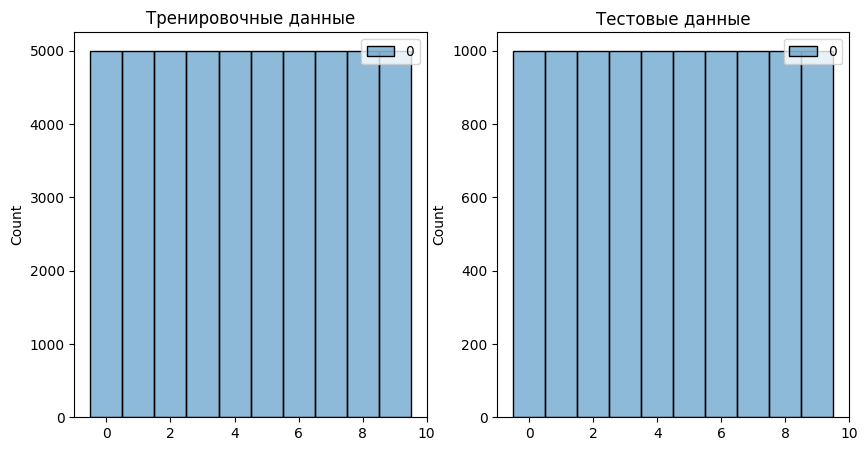

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].set_title("Тренировочные данные")
sb.histplot(ax = axes[0], data = train_labels, discrete = True)

axes[1].set_title("Тестовые данные")
sb.histplot(ax = axes[1], data = test_labels, discrete = True)
plt.show()

## Подготовка данных

In [ ]:
train_images[0][0][0]

array([59, 62, 63], dtype=uint8)

In [ ]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

In [ ]:
train_images_norm[0][0][0]

array([0.23137255, 0.24313725, 0.24705882])

In [ ]:
# Прервать обучение при достижении заданной точности

class StopWhenAccuracy(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.98:
      print("Stop!")
      self.model.stop_training = True

stop_condition =  StopWhenAccuracy()

In [ ]:
# One-Hot кодирование для Keras

train_labels_enc = utils.to_categorical(train_labels, len(class_names))
test_labels_enc  = utils.to_categorical(test_labels,  len(class_names))

In [ ]:
# Проверка
print(train_labels[0])
print(train_labels_enc[0])

[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Построение модели

In [ ]:
input_shape = train_images_norm[0].shape
cifar10 = None

if USE_PRE_TRAINED_CNN:
  cifar10 = load_model("cifar10.keras")
else:
  cifar10 = Sequential(
    [
        Conv2D(filters = 32, kernel_size = 3, padding = "same", input_shape = input_shape, activation = "relu"),
        Conv2D(filters = 32, kernel_size = 3, activation = "relu"),
        MaxPool2D(pool_size = 2),
        Dropout(0.25),

        Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
        Conv2D(filters = 64, kernel_size = 3, activation = "relu"),
        MaxPool2D(pool_size = 2),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation = "relu"),
        Dense(256, activation = "relu"),
        Dense(64, activation = "relu"),
        Dropout(0.5),

        Dense(len(class_names), activation = "softmax")
    ]
  )

In [ ]:
input_shape = train_images_norm[0].shape
cifar10 = None

if USE_PRE_TRAINED_CNN:
  cifar10 = load_model("cifar10.keras")
else:
  cifar10 = Sequential(
    [
        Conv2D(filters = 32, kernel_size = 3, padding = "same", input_shape = input_shape, activation = "relu"),
        Conv2D(filters = 32, kernel_size = 3, activation = "relu"),
        MaxPool2D(pool_size = 2, padding = "same"),
        Dropout(0.25),

        Conv2D(filters = 32, kernel_size = 3, padding = "same", input_shape = input_shape, activation = "relu"),
        Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"),
        MaxPool2D(pool_size = 2, padding = "same"),
        Dropout(0.25),

        Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
        Conv2D(filters = 64, kernel_size = 3, activation = "relu"),
        MaxPool2D(pool_size = 2),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation = "relu"),
        Dense(256, activation = "relu"),
        Dense(64, activation = "relu"),
        Dropout(0.5),

        Dense(len(class_names), activation = "softmax")
    ]
  )

In [ ]:
cifar10.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 conv2d_26 (Conv2D)          (None, 15, 15, 32)        9248      
                                                      

In [ ]:
if not USE_PRE_TRAINED_CNN:
  cifar10.compile(
      optimizer = optimizers.Adam(learning_rate = 0.0005),  # оптимизатор - адаптивный градиентный спуск с моментом Нестерова
      loss = losses.categorical_crossentropy,               # Функция потерь, кросс энтропия лучше чем MSE в задаче классицикации: https://colab.research.google.com/drive/1AdbtsRkX0jRVByuAKJxchYPcciTgFpqh#scrollTo=EJJKBT3MPtrL&line=9&uniqifier=1
      metrics = "accuracy",                                 # accuracy подойдёт, т.к. баланс классов хороший

      # без использования one-hot кодирования
      # loss = losses.sparse_categorical_crossentropy,
      # metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  )

  cifar10.build(input_shape = input_shape)

## Визуализация модели

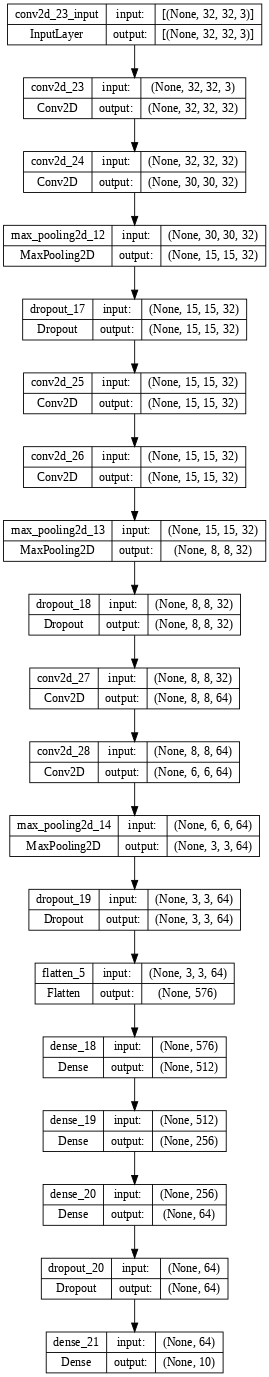

In [ ]:
tf.keras.utils.plot_model(
    cifar10,
    # to_file="model.png",
    show_shapes = True,
    show_layer_names = True,
    rankdir = "TB",
    expand_nested = True,
    dpi = 64,
)


## Аугментация

In [ ]:
if USE_AUGMENTATION:
  datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        zca_epsilon = 1e-06,  # epsilon for ZCA whitening
        rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range = 0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range = 0.1,
        shear_range = 0.0,  # set range for random shear
        zoom_range = 0.0,  # set range for random zoom
        channel_shift_range = 0.0,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode = "nearest",
        cval = 0.0,  # value used for fill_mode = "constant"
        horizontal_flip = True,  # randomly flip images
        vertical_flip = False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale = None,
        # set function that will be applied on each input
        preprocessing_function = None,
        # image data format, either "channels_first" or "channels_last"
        data_format = None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split = 0.0
  )

  datagen.fit(train_images_norm)

## Обучение

In [ ]:
data = None

if USE_AUGMENTATION:
  data = datagen.flow(train_images_norm, train_labels_enc, shuffle = True)

  data_unshuffled = datagen.flow(train_images_norm, train_labels_enc, shuffle = False)
  print("Используется аугментация")

  random_image_index = randint(0, len(data_unshuffled) - 1)
  normal_image_index = random_image_index * 32

  plot_images("Normal version", 16, 2, train_images_norm[normal_image_index : normal_image_index + 32], train_labels[normal_image_index : normal_image_index + 32])
  plot_images("Augmented version", 16, 2, data_unshuffled[random_image_index][0][0:32], data_unshuffled[random_image_index][1])
else:
  data = (train_images_norm, train_labels_enc)
  print("Аугментация НЕ используется")

Аугментация НЕ используется


In [ ]:
if not USE_PRE_TRAINED_CNN:
  global history
  history = cifar10.fit(
      x = train_images_norm,
      y = train_labels_enc,
      validation_data = (test_images_norm, test_labels_enc),
      verbose = 2,
      epochs = 32,
      workers = -1,
      use_multiprocessing = True,
      callbacks=[stop_condition, TqdmCallback(verbose = 2)],
      shuffle = True
  )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 1/32
1563/1563 - 16s - loss: 1.8489 - accuracy: 0.3003 - val_loss: 1.3838 - val_accuracy: 0.4943 - 16s/epoch - 10ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 2/32
1563/1563 - 12s - loss: 1.4079 - accuracy: 0.4942 - val_loss: 1.2023 - val_accuracy: 0.5607 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 3/32
1563/1563 - 12s - loss: 1.2557 - accuracy: 0.5588 - val_loss: 1.1321 - val_accuracy: 0.5971 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 4/32
1563/1563 - 12s - loss: 1.1475 - accuracy: 0.5991 - val_loss: 0.9945 - val_accuracy: 0.6516 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 5/32
1563/1563 - 14s - loss: 1.0711 - accuracy: 0.6336 - val_loss: 0.9184 - val_accuracy: 0.6840 - 14s/epoch - 9ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 6/32
1563/1563 - 13s - loss: 0.9975 - accuracy: 0.6576 - val_loss: 0.8576 - val_accuracy: 0.7029 - 13s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 7/32
1563/1563 - 12s - loss: 0.9436 - accuracy: 0.6788 - val_loss: 0.9012 - val_accuracy: 0.6934 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 8/32
1563/1563 - 12s - loss: 0.8930 - accuracy: 0.6980 - val_loss: 0.7891 - val_accuracy: 0.7281 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 9/32
1563/1563 - 13s - loss: 0.8520 - accuracy: 0.7143 - val_loss: 0.7516 - val_accuracy: 0.7469 - 13s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 10/32
1563/1563 - 12s - loss: 0.8183 - accuracy: 0.7220 - val_loss: 0.7402 - val_accuracy: 0.7499 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 11/32
1563/1563 - 12s - loss: 0.7925 - accuracy: 0.7349 - val_loss: 0.7458 - val_accuracy: 0.7399 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 12/32
1563/1563 - 12s - loss: 0.7598 - accuracy: 0.7439 - val_loss: 0.7000 - val_accuracy: 0.7647 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 13/32
1563/1563 - 12s - loss: 0.7373 - accuracy: 0.7530 - val_loss: 0.6929 - val_accuracy: 0.7649 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 14/32
1563/1563 - 12s - loss: 0.7155 - accuracy: 0.7614 - val_loss: 0.6678 - val_accuracy: 0.7704 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 15/32
1563/1563 - 12s - loss: 0.6937 - accuracy: 0.7670 - val_loss: 0.6566 - val_accuracy: 0.7777 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 16/32
1563/1563 - 12s - loss: 0.6713 - accuracy: 0.7742 - val_loss: 0.6607 - val_accuracy: 0.7759 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 17/32
1563/1563 - 12s - loss: 0.6502 - accuracy: 0.7826 - val_loss: 0.6728 - val_accuracy: 0.7737 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 18/32
1563/1563 - 12s - loss: 0.6314 - accuracy: 0.7857 - val_loss: 0.6642 - val_accuracy: 0.7815 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 19/32
1563/1563 - 13s - loss: 0.6227 - accuracy: 0.7915 - val_loss: 0.6551 - val_accuracy: 0.7840 - 13s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 20/32
1563/1563 - 12s - loss: 0.5999 - accuracy: 0.8010 - val_loss: 0.6454 - val_accuracy: 0.7814 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 21/32
1563/1563 - 12s - loss: 0.5931 - accuracy: 0.8019 - val_loss: 0.6598 - val_accuracy: 0.7861 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 22/32
1563/1563 - 12s - loss: 0.5779 - accuracy: 0.8069 - val_loss: 0.6464 - val_accuracy: 0.7891 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 23/32
1563/1563 - 14s - loss: 0.5624 - accuracy: 0.8130 - val_loss: 0.6573 - val_accuracy: 0.7880 - 14s/epoch - 9ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 24/32
1563/1563 - 12s - loss: 0.5535 - accuracy: 0.8151 - val_loss: 0.6841 - val_accuracy: 0.7781 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 25/32
1563/1563 - 12s - loss: 0.5480 - accuracy: 0.8163 - val_loss: 0.6369 - val_accuracy: 0.7921 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 26/32
1563/1563 - 13s - loss: 0.5398 - accuracy: 0.8182 - val_loss: 0.6437 - val_accuracy: 0.8030 - 13s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 27/32
1563/1563 - 13s - loss: 0.5211 - accuracy: 0.8238 - val_loss: 0.6119 - val_accuracy: 0.7998 - 13s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 28/32
1563/1563 - 13s - loss: 0.5182 - accuracy: 0.8260 - val_loss: 0.6282 - val_accuracy: 0.7998 - 13s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 29/32
1563/1563 - 12s - loss: 0.5153 - accuracy: 0.8271 - val_loss: 0.6594 - val_accuracy: 0.7948 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 30/32
1563/1563 - 12s - loss: 0.5089 - accuracy: 0.8277 - val_loss: 0.6912 - val_accuracy: 0.7839 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 31/32
1563/1563 - 12s - loss: 0.4910 - accuracy: 0.8317 - val_loss: 0.6475 - val_accuracy: 0.7985 - 12s/epoch - 8ms/step


  0%|          | 0.00/1.56k [00:00<?, ?batch/s]

Epoch 32/32
1563/1563 - 12s - loss: 0.4823 - accuracy: 0.8381 - val_loss: 0.6891 - val_accuracy: 0.7851 - 12s/epoch - 8ms/step


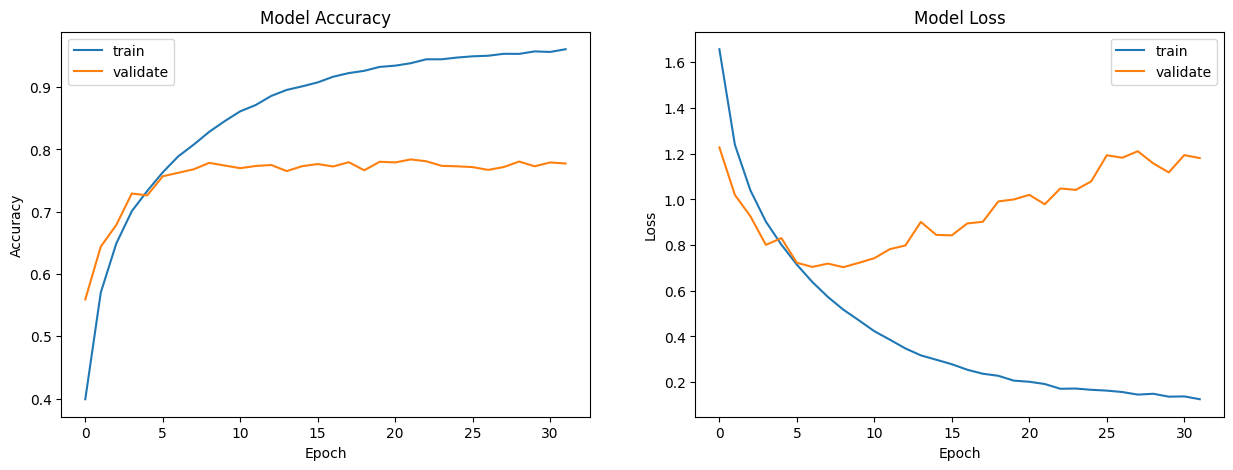

In [ ]:
if not USE_PRE_TRAINED_CNN:
  plot_data = [
      {
          "name": "Accuracy",
          "plots": ["accuracy", "val_accuracy"]
      },
      {
          "name": "Loss",
          "plots": ["loss", "val_loss"]
      }
  ]

  fig, axes = plt.subplots(1, 2, figsize = (15,5))
  for i in range(len(plot_data)):
    d = plot_data[i]
    name = d["name"]
    for plot_name in d["plots"]:
      axes[i].plot(history.history[plot_name])
    axes[i].set_title(f"Model {name}")
    axes[i].set_ylabel(name)
    axes[i].set_xlabel("Epoch")
    axes[i].legend(["train", "validate"])
  plt.show()

## Проверка модели

In [ ]:
predictions = cifar10.predict(test_images_norm)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print(predictions[0])
print(predictions[0].max())
print(predictions[0].argmax())

[9.7468558e-07 2.2750737e-09 4.6323908e-05 8.4937984e-01 5.0486898e-07
 1.1497598e-01 3.5341796e-02 2.5718216e-06 2.5188140e-04 2.5737622e-08]
0.84937984
3


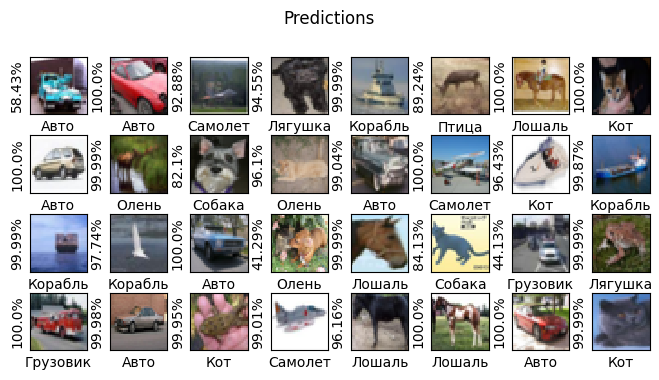

In [ ]:
i = 0
predictions_labels = np.empty(len(predictions), dtype = object)

for p in predictions:
  predictions_labels[i] = [p.argmax(), p.max()]
  i += 1
plot_rnd_images("Predictions", 32, test_images_norm, predictions_labels)

In [ ]:
#cifar10.save_weights("weights.h5")
#cifar10.save("cifar10.keras")